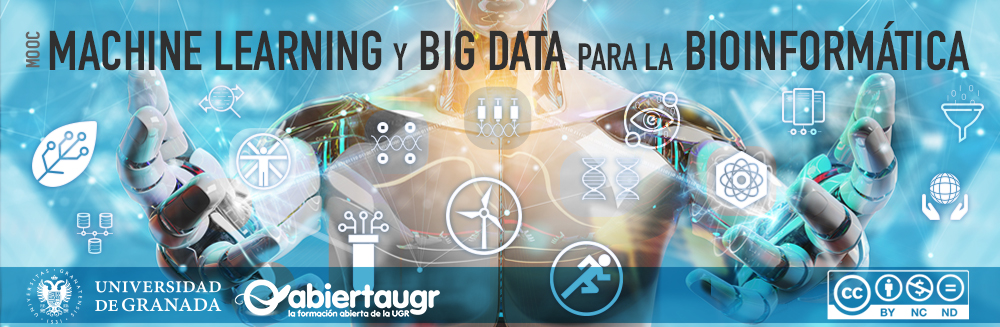
# **Machine Learning y Big Data para la Bioinformática**
## **Módulo 6 - Aprendizaje No Supervisado: Clustering y Reglas de Asociación**
## **Cápsula 2 - Clustering**

**Autores**: 


*Por* **Carlos Cano Gutiérrez**

Profesor Titular de la Universidad de Granada. Departamento de Ciencias de Computación e Inteligencia Artificial. 


**Recordatorio: Introducción a NoteBook**

Dentro de este cuaderno (*NoteBook*), se le guiará paso a paso desde la carga de un conjunto de datos hasta el análisis descriptivo de su contenido.

El cuaderno de *Jupyter* (Python) es un enfoque que combina bloques de texto (como éste) junto con bloques o celdas de código. La gran ventaja de este tipo de celdas, es su interactividad, ya que pueden ser ejecutadas para comprobar los resultados directamente sobre las mismas. *Muy importante*: el orden las instrucciones es fundamental, por lo que cada celda de este cuaderno debe ser ejecutada secuencialmente. En caso de omitir alguna, puede que el programa lance un error, así que se deberá comenzar desde el principio en caso de duda.

Antes de nada:

Es muy muy importante que al comienzo se seleccione "*Abrir en modo de ensayo*" (draft mode), arriba a la izquierda. En caso contrario, no permitirá ejecutar ningún bloque de código, por cuestiones de seguridad. Cuando se ejecute el primero de los bloques, aparecerá el siguiente mensaje: "*Advertencia: Este cuaderno no lo ha creado Google.*". No se preocupe, deberá confiar en el contenido del cuaderno (*NoteBook*) y pulsar en "Ejecutar de todos modos".

¡Ánimo!

Haga clic en el botón "play" en la parte izquierda de cada celda de código. Las líneas que comienzan con un hashtag (#) son comentarios y no afectan a la ejecución del programa.

También puede pinchar sobre cada celda y hacer "*ctrl+enter*" (*cmd+enter* en Mac).

Cada vez que ejecute un bloque, verá la salida justo debajo del mismo. La información suele ser siempre la relativa a la última instrucción, junto con todos los `print()` (orden para imprimir) que haya en el código.

## **ÍNDICE**


En este *notebook*: 
1. Aprenderemos a aplicar distintos algoritmos de clustering (jerárquico y K-medias) para identificar grupos de genes y muestras en matrices de expresión genética.    
2. Aprenderemos a interpretar los resultados de los algoritmos de clustering. Evaluaremos visualmente la bondad de los resultados obtenidos.  
3. Aprenderemos a utilizar métricas para evaluar de forma automática la bondad de los resultados del clustering y elegir el número de grupos ($K$) que mejor recoja la estructura de los datos.   

Contenidos: 
1. [Introducción al problema](#problem)
2. [Clustering Jerárquico](#hierarchical)   
3. [Clustering por particionamiento: K-medias](#kmeans)   
4. [Contenido adicional](#additional)   




## **INSTALACIÓN DE BIBLIOTECAS**

In [ ]:
!pip install fastcluster
!pip install yellowbrick


     |████████████████████████████████| 163kB 5.9MB/s 


##**1. INTRODUCCIÓN AL PROBLEMA**


Los datos de expresión genética suponen una fuente muy valiosa de información para entender cómo funcionan los mecanismos de regulación genética. Recordamos que en el módulo 2 aprendimos a interpretar este tipo de datos y cómo se representan. 

Una matriz de expresión es una matriz numérica $E$ que contiene el valor de expresión de distintos genes (uno por fila) para distintas muestras (una por columna). De este modo, notaremos que el valor de expresión del gen $i$ para la muestra $j$ se coloca en la casilla $E[i][j]$ (matriz $E$, fila $i$, columna $j$). 

Según la técnica experimental empleada para obtener estos valores de expresión, éstos pueden representar distintas magnitudes físicas, por ejemplo, un recuento del número de copias de cada gen, el ratio del número de copias respecto a un gen control o *housekeeping*, la intensidad de una señal fluorescente, etc. En cualquiera de estos casos, la matriz de expresión recoge estos valores numéricos que representan el grado de actividad o expresión de cada gen en cada una de las muestras. Es requisito que los valores de expresión de los genes y muestras que aparecen en la misma matriz de expresión hayan sido obtenidos todos ellos con la misma técnica experimental y hayan sido sometidos al mismo proceso de preprocesamiento y normalización (para que los datos estén en la misma escala y sean directamente comparables entre sí). En otro caso, no hay garantías de que el análisis Cluster que realicemos arroje resultados fiables. 

En la Cápsula 1 aprendimos que el Clustering se utiliza para identificar grupos en los datos sin utilizar ninguna información disponible *a priori* sobre categorías, tipos, clases o grupos conocidos en los datos. En este problema, el clustering nos permitiría responder a las siguientes preguntas:  

1. ¿Existe alguna manera de agrupar los genes en base a su perfil de expresión? Es decir, ¿podemos identificar genes que se comporten de la misma manera para todas las muestras del estudio?
Responder a esta pregunta resultará de interés porque si un grupo de genes se comporta de la misma manera en distintas muestras biológicas probablemente implica que esos genes participan de los mismos procesos biológicos o juegan un papel biológico relacionado en los procesos de regulación genética. Esto puede ayudarnos a entender los mecanismos que regulan la enfermedad y sus bases moleculares. 


2. ¿Existe alguna manera de agrupar las muestras en base a su perfil de expresión? O reformulado, ¿podemos identificar grupos de muestras similares? Responder a esta pregunta nos permitirá identificar grupos de pacientes con perfil de expresión genética similar, y por tanto, pacientes candidatos a recibir un mismo diagnóstico, tratamiento o pronóstico. 

Nuestra capacidad para responder adecuadamente a estas dos preguntas dependerá de varios factores: 
1. La calidad de los datos de partida.
2. El volumen de datos de partida.
3. Nuestra pericia para realizar un preprocesamiento, normalización y análisis clúster adecuado, riguroso y exhaustivo. 

Cuanto mayor sea el valor de estos tres factores, más cerca estaremos de dar una respuesta acertada a las preguntas biológicas anteriores.

###1.1. Lectura de datos

Para ilustrar distintos algoritmos de Clustering y su funcionamiento sobre una matriz de expresión, vamos a cargar en primer lugar la matriz de expresión de 1500 genes que obtuvimos en el Módulo 2

In [ ]:
# Importamos la librería pandas con el alias 'pd'
import pandas as pd

# Almacenamos el enlace a nuestros datos en la variable 'url_datos'
url_datos = 'https://drive.google.com/uc?id=1OzVlp4RsT63W6d18_Zc5WmUonLXMDNL8'

# El método read_csv permite leer un fichero de texto separado por un carácter que actúa como delimitador de campo, en nuestro caso, el tabulador ('\t')
mexpr = pd.read_csv(url_datos, delimiter='\t')

mexpr

TCGA-D9-A4Z6-06  TCGA-EE-A2MQ-06  ...  TCGA-DA-A1I2-06  TCGA-D3-A2JK-06
TYRP1            7.941545         2.750463  ...        -0.236019         3.225224
RPS4Y1           3.475878        -9.252088  ...        -1.552534         3.047051
KRT6A           -2.734785         0.420073  ...        -2.734785         5.528256
XIST            -2.903056         8.320289  ...        -2.143789        -3.487538
KRT14           -3.653679        -2.898792  ...        -3.100319         5.018664
...                   ...              ...  ...              ...              ...
PKIA            -1.922342        -2.127497  ...        -1.456395        -4.827982
EBF3             5.692378         0.087663  ...        -0.161120        -0.513140
TMEM100         -0.362261        -0.211399  ...        -0.962664        -2.361179
PLEKHG4B         5.755474         0.199884  ...        -0.995689        -3.009616
SLA2            -2.970178        -0.390041  ...         0.015362        -2.161355

[1500 rows x 473 columns]

##**2. CLUSTERING JERÁRQUICO**


Los algoritmos de Clustering Jerárquico toman un conjunto de instancias (en nuestro caso, genes o muestras), calculan las distancias entre las instancias según la medida de distancia que indiquemos y construyen un dendrograma. Como se introdujo en la Cápsula 1 de este módulo, un dedrograma es una jerarquía de clusters, es decir, representa cómo las instancias se relacionan entre sí dando lugar a agrupamientos de distinto tamaño. 



La siguiente celda de código ilustra cómo llevar a cabo el clustering jerárquico sobre genes y sobre muestras utilizando la función `clustermap` de la biblioteca `seaborn`


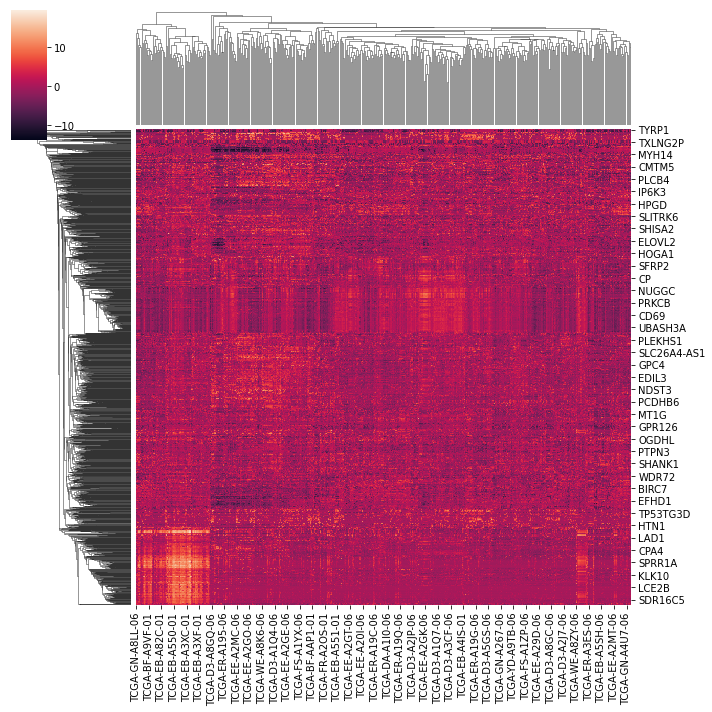

In [ ]:
# Librerías
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
 
# Representación gráfica por defecto
sns.clustermap(mexpr)


Para entender mejor los dendrogramas resultantes, vamos a seleccionar sólo una porción de la matriz de expresión (50 genes y 20 muestras) y repetimos este proceso

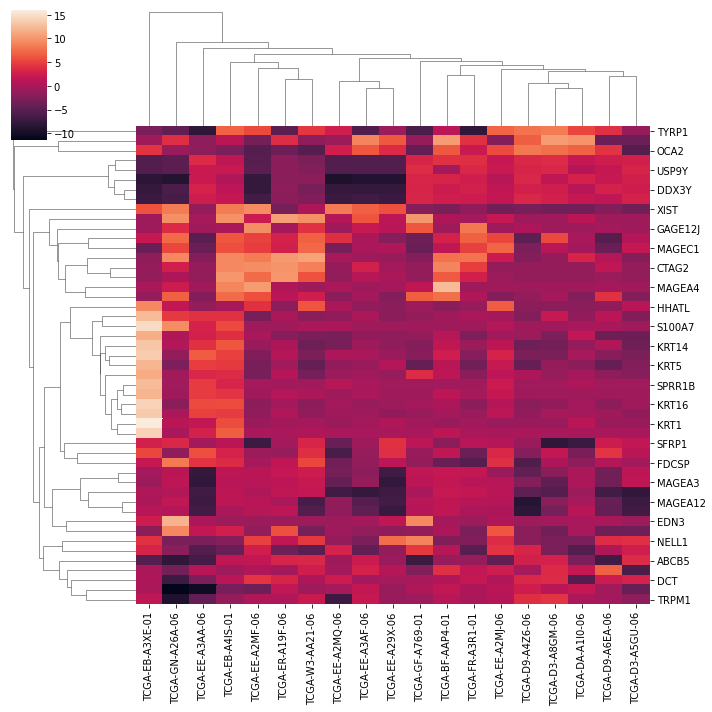

In [ ]:
# Definimos una matriz de expresión mas pequeña para jugar con ella: mexpr_toy
mexpr_toy = mexpr.iloc[0:49, 0:19]
sns.clustermap(mexpr_toy)


Los resultados de los algoritmos de Clustering jerárquico se suelen representar mediante este tipo de representación gráfica tipo *heatmap*, sobre la cual se indica el dendrograma obtenido para las filas y/o columnas. Esta representación es muy útil para validar visualmente los grupos obtenidos. 

Observa que con esta función hemos aplicado dos veces el mismo algoritmo de clustering: 

1.   Clustering de los genes (utilizando los genes como instancias y las muestras como variables), obteniendo el dendrograma que se muestra sobre las filas, y, de forma independiente,

2.   Clustering sobre las muestras (utilizando las muestras como instancias y los genes como variables), obteniendo el dendrograma que se muestra sobre las columnas. 

Observa los patrones de colores en el heatmap anterior ¿Crees que el algoritmo de clustering revela algunos grupos homogéneos en los datos? ¿serías capaz de identificar visualmente estos grupos?

En este caso, resulta relativamente sencillo identificar algunos grupos de genes que parecen mostrar patrones de expresión *similares*. Si anotamos manualmente sobre la figura estos grupos, podríamos identificar algo parecido a lo que muestra la siguiente figura:


![Figura 1. Anotaciones manuales sobre los resultados del clustering identificando visualmente grupos de genes similares](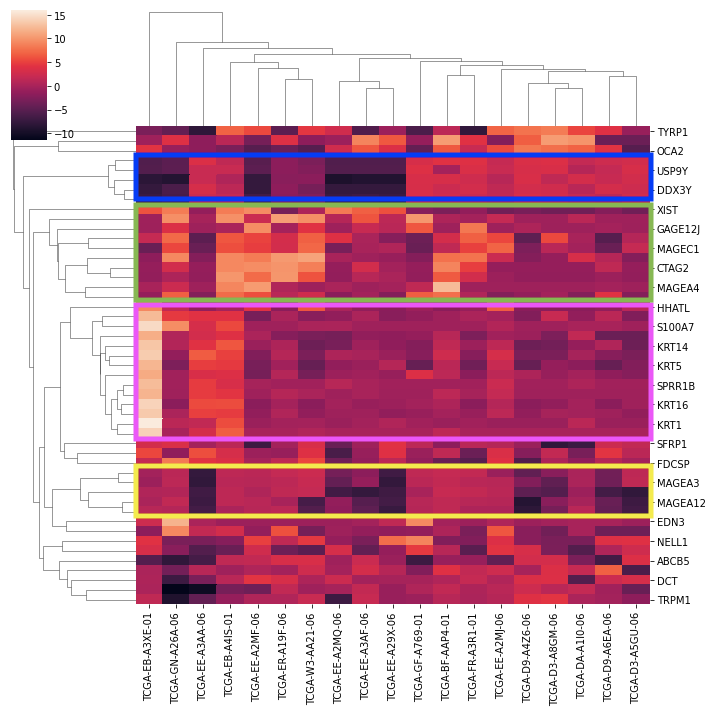 )

*Figura 1. Anotaciones manuales sobre los resultados del clustering identificando visualmente grupos de genes similares*

El grupo rosa y azul muestran una homogeneidad interna muy elevada (es decir, sus genes se comportan de manera muy similar entre sí). El grupo verde parece algo más heterogéneo. Observa que esta homogeneidad/heterogeneidad interna de los grupos está indicada también en el dendrograma: a menor longitud de las ramas que conectan las filas o los grupos de filas, más similares u homogéneos son los grupos resultantes, y viceversa.  

La identificación de grupos no se lleva a cabo manualmente, como hemos hecho en este ejemplo, sino que se realiza de manera automática. Aprenderemos más adelante cómo hacerlo. 

Es de destacar en este ejemplo que el grupo de genes azul muestra un perfil diferenciado para dos conjuntos de muestras. A tenor de la expresión de los genes de este grupo, parece que podríamos dividir las muestras (columnas) de este pequeño estudio en dos conjuntos, tal y como aparece en la siguiente imagen. 


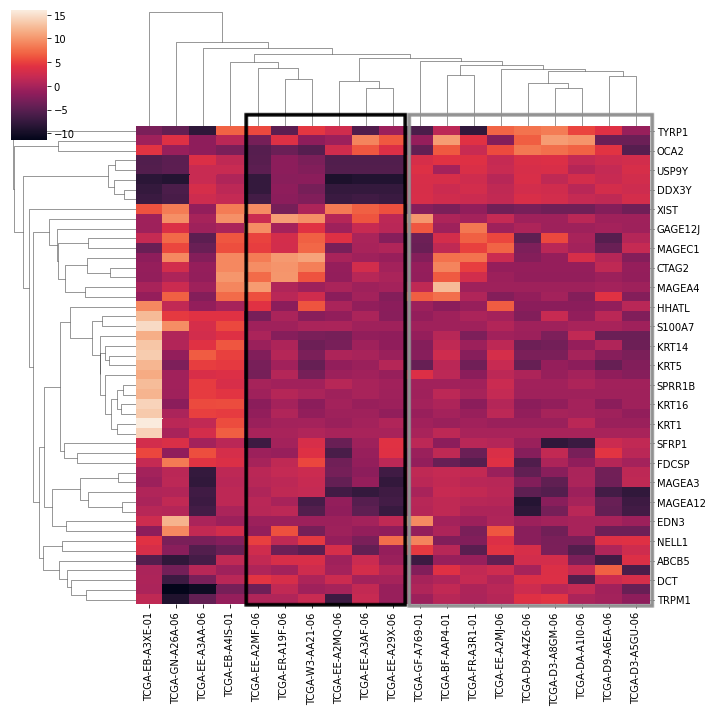

*Figura 2. Anotaciones manuales sobre los resultados del clustering identificando visualmente dos grupos de muestras*

El grupo de muestras negro presenta un valor de expresión bajo para los genes del cluster azul, mientras que el grupo de muestras gris presenta un valor de expresión elevado para estos mismos genes. Además, la expresión del grupo de genes rosa parece indicar también una expresión diferenciada que permite discriminar estos dos grupos de muestras (negro y gris) de otras muestras que no se parecen al resto y quedarían conformando su propio grupo cada una (se denominan  *outliers*). Es de destacar que estos dos grupos de muestras (negro y gris) que hemos identificado visualmente no encajan del todo bien con el dendrograma obtenido por el algoritmo de clustering (el dendrograma que aparece arriba, sobre las columnas). Veamos si cambiando algunos parámetros del algoritmo podemos obtener dendrogramas que recojan mejor los patrones que hemos identificado visualmente. 

###2.1. Medidas de distancia entre instancias y entre grupos de instancias

####2.1.1. Medidas de distancia entre instancias

Para utilizar distintas medidas de distancia entre instancias tenemos que cambiar el valor a la variable `metric`. Esta variable tiene muchos valores posibles ([consultar la ayuda para conocerlos todos](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)), pero destacamos algunas muy populares para variables continuas: `euclidean`, `cosine`, 
`correlation`, `cityblock`(manhattan), `chebyshev` y `minkowski`. 


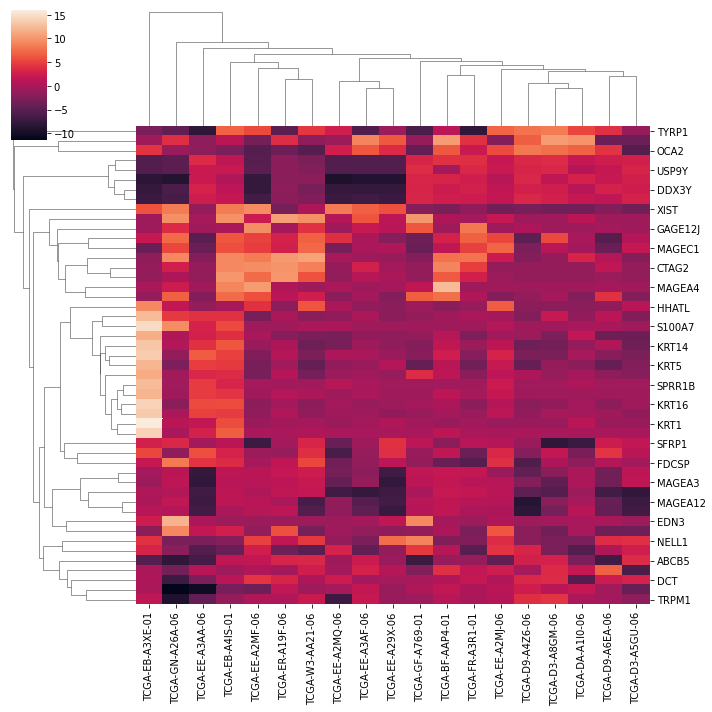

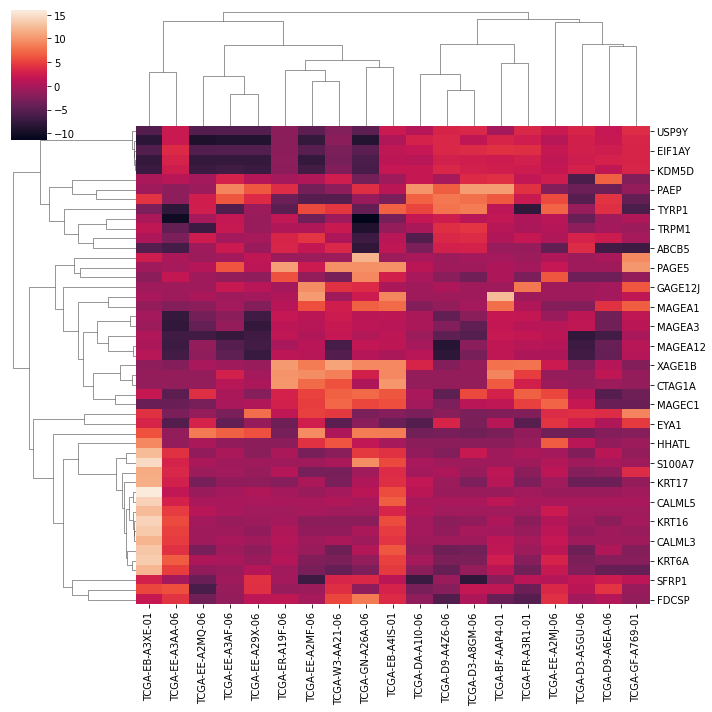

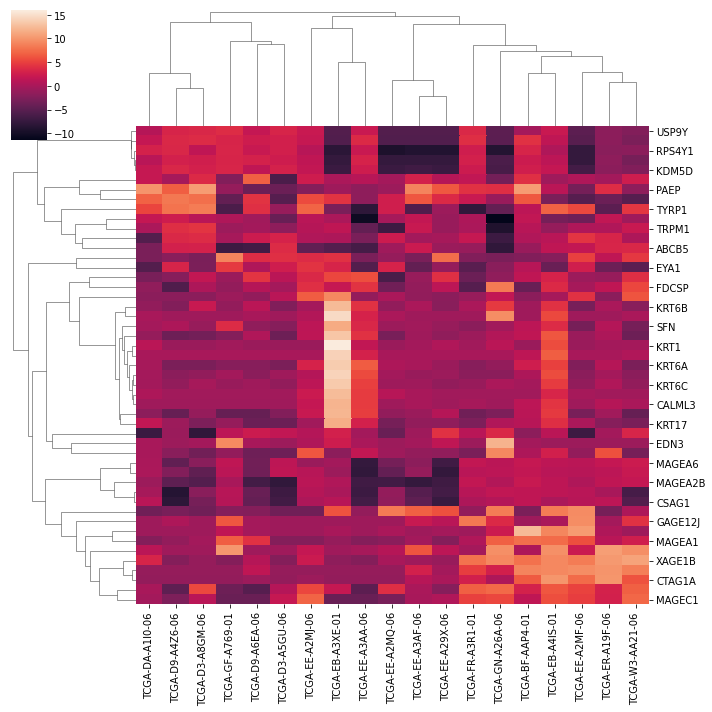

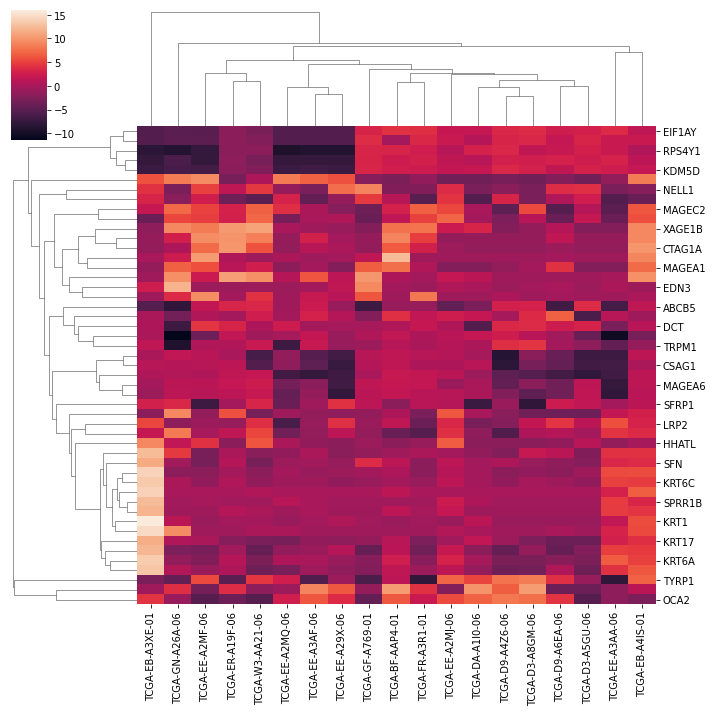

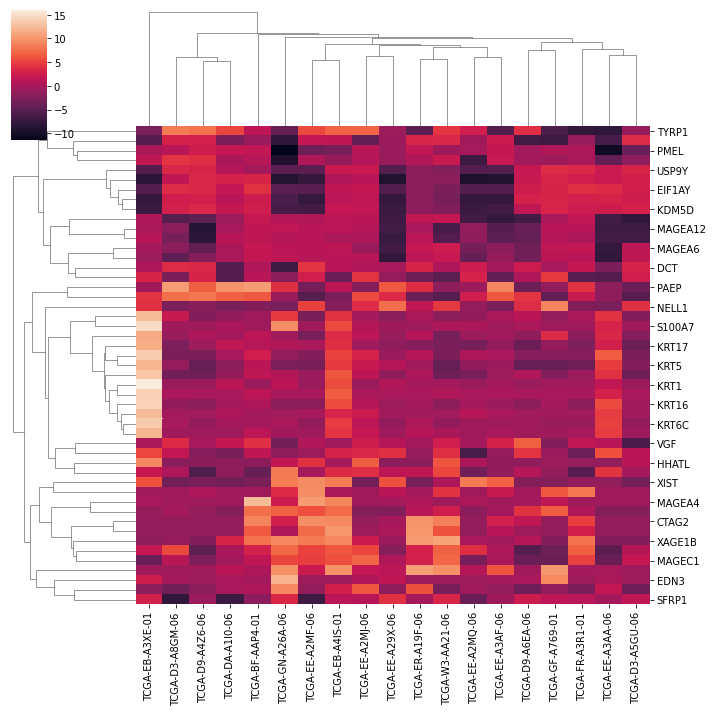

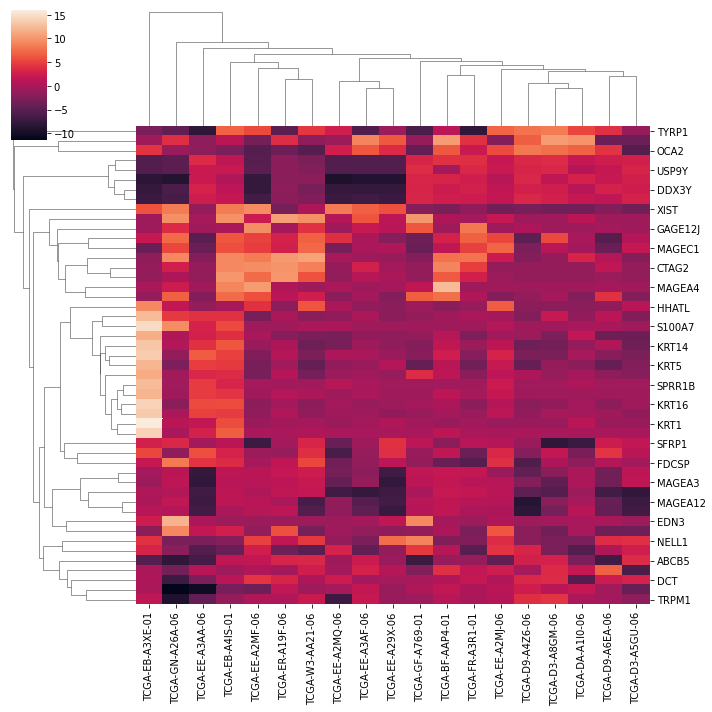

In [ ]:
sns.clustermap(mexpr_toy, metric="euclidean")
sns.clustermap(mexpr_toy, metric="correlation")
sns.clustermap(mexpr_toy, metric="cosine")
sns.clustermap(mexpr_toy, metric="cityblock")
sns.clustermap(mexpr_toy, metric="chebyshev")
sns.clustermap(mexpr_toy, metric="minkowski")




El primer plot es el que ya habíamos analizado, porque por defecto se utiliza la distancia Euclídea para elaborar los heatmaps. De esta serie, parece que la segunda figura es la que ofrece el dendrograma de muestras más acorde a las muestras que habíamos identificado manualmente sobre los resultados anteriores. Observemos de nuevo este resultado: 




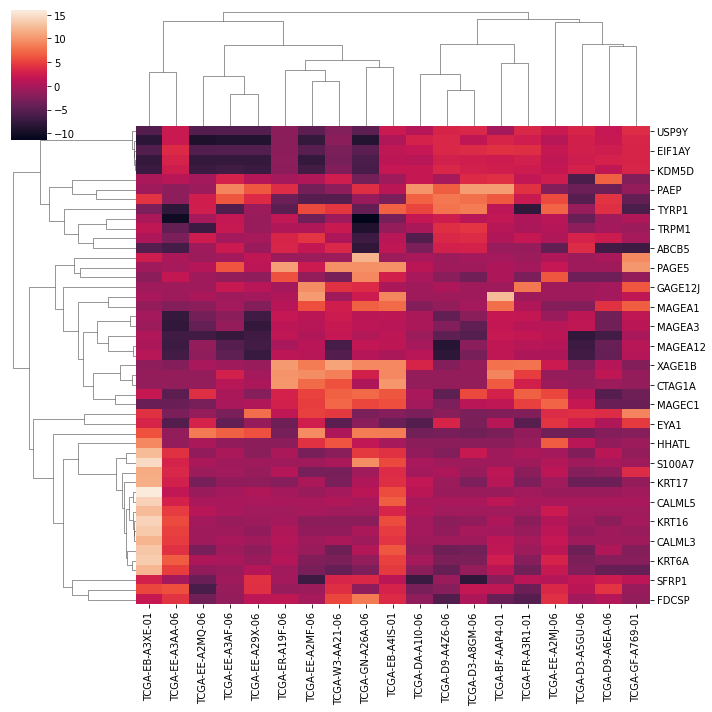

In [ ]:
sns.clustermap(mexpr_toy, metric="correlation")


Anotamos manualmente este resultado para comprobar que los clusters más homogéneos de genes (azul y rosa) y muestras (negro y gris) son claramente identificables en este heatmap y los dendrogramas correspondientes son coherentes con estos grupos. 

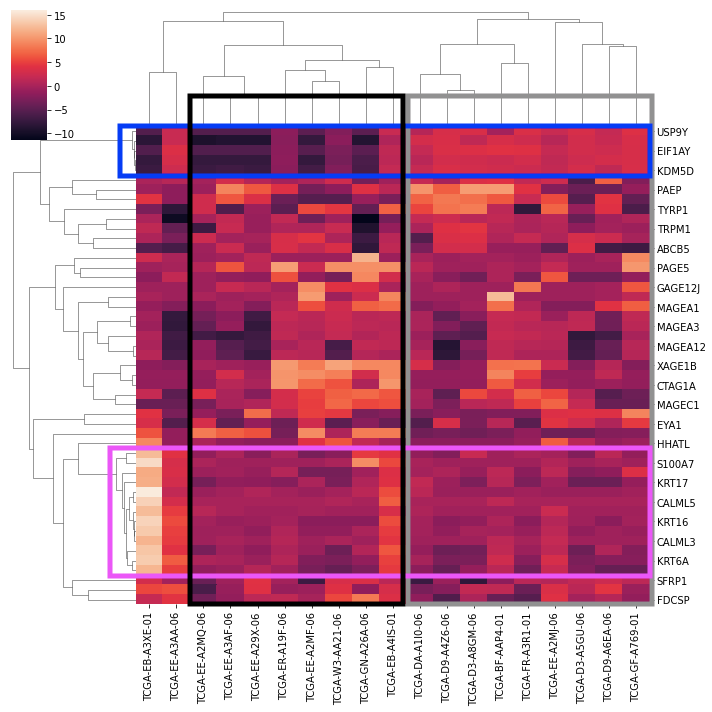

*Figura 3. Anotaciones manuales sobre los resultados del clustering identificando visualmente grupos de genes y muestras similares*


####2.1.2. Medidas de distancia entre clusters

Una vez que hemos aprendido los parámetros que podemos modificar para definir la medida de distancia entre instancias, necesitamos ahora especificar la forma de calcular la medida de distancia entre grupos, tal y como se explicó en la Cápsula 1 de este módulo. Para ello, elegimos un método en el argumento `method`: `single`, `complete`, `average`, `centroid`, `median`, `ward` 

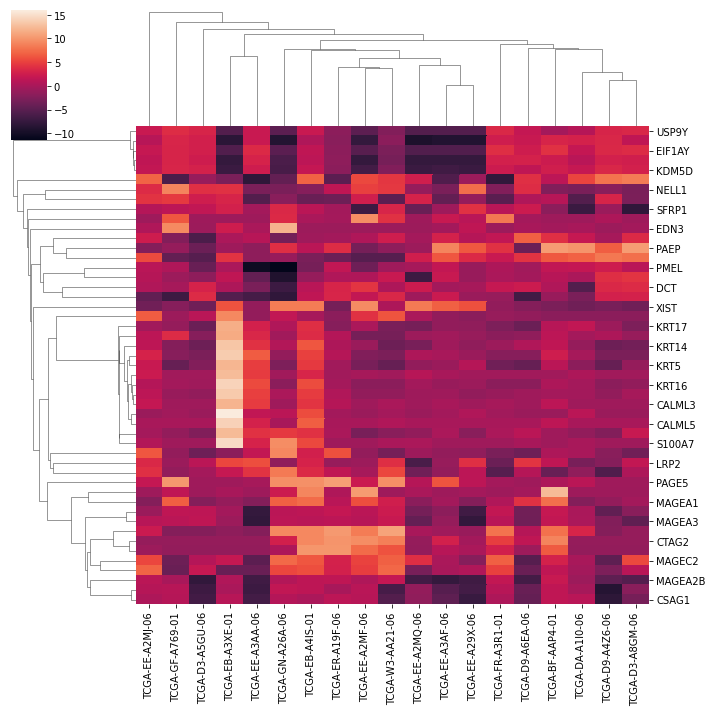

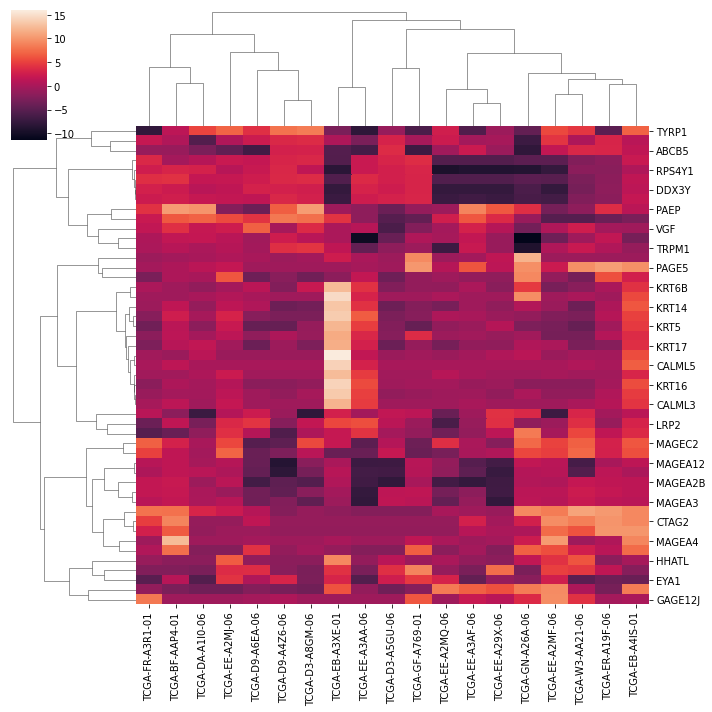

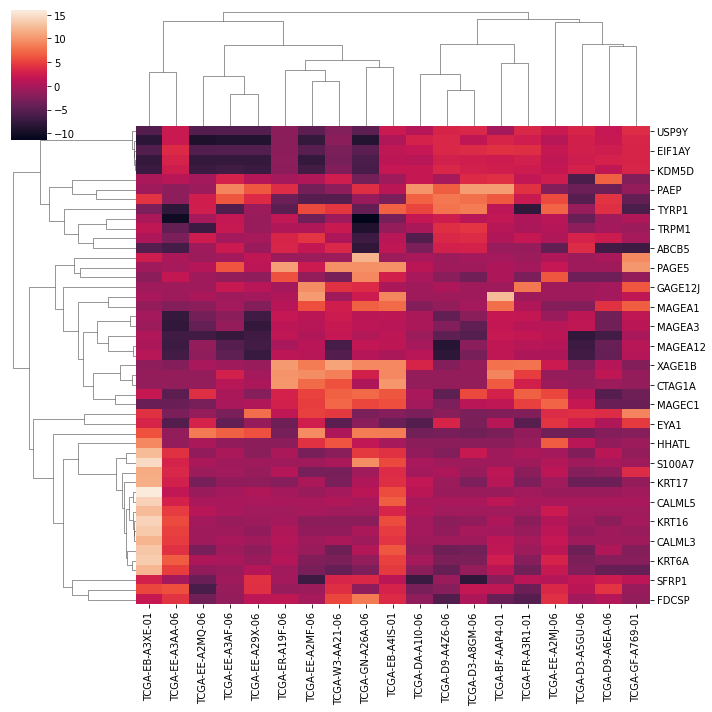

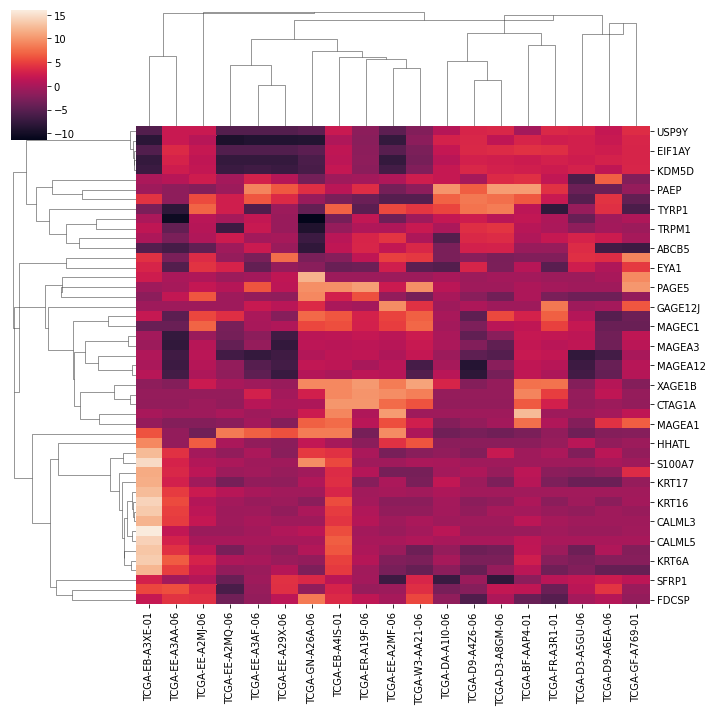

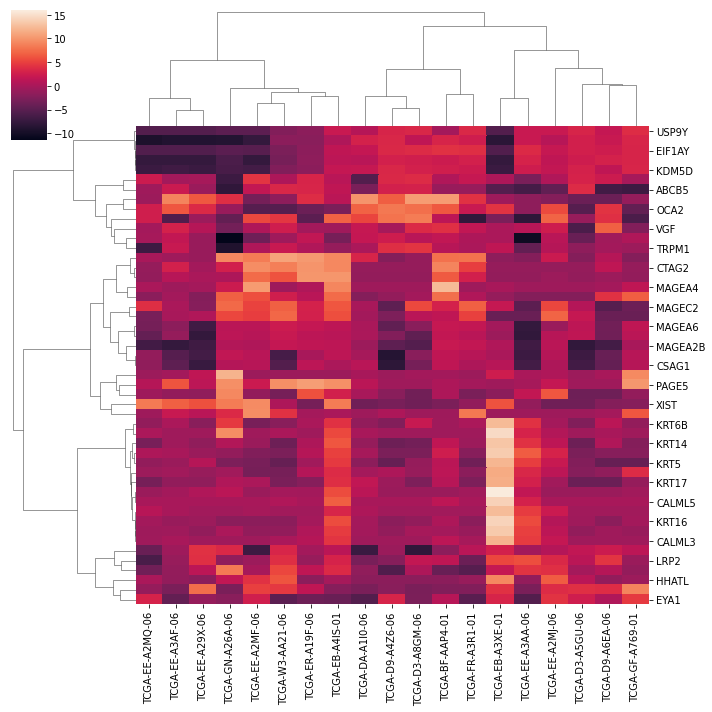

In [ ]:
sns.clustermap(mexpr_toy, metric="correlation", method="single")
sns.clustermap(mexpr_toy, metric="correlation", method="complete")
sns.clustermap(mexpr_toy, metric="correlation", method="average")
sns.clustermap(mexpr_toy, metric="correlation", method="centroid")
sns.clustermap(mexpr_toy, metric="correlation", method="ward")



A simple vista, los dendrogramas que más parecen reflejar las estructuras que habíamos identificado de la inspección visual de los *heatmaps* son los obtenidos por los métodos `average` (es el resultado que ya habíamos analizado en la celda de código anterior porque es el valor por defecto para `method`) y `ward`. 

Es importante destacar aquí que la bondad de los resultados obtenidos depende de ambas métricas: la métrica elegida para calcular la distancia entre instancias y el método para calcular la distancia entre grupos. Es decir, estas métricas son mutuamente dependientes. En este caso, del análisis de este subconjunto de datos, podríamos extraer la conclusión preliminar de que la métrica `correlation` funciona mejor para estos datos con los métodos `average` y `ward`. Si cambiamos la métrica entre objetos, deberíamos reconsiderar, de nuevo, todos los métodos de cálculo de distancia entre grupos, para encontrar la mejor combinación de ambas. 



Por ejemplo, si queremos evaluar resultados para la distancia `euclidean`

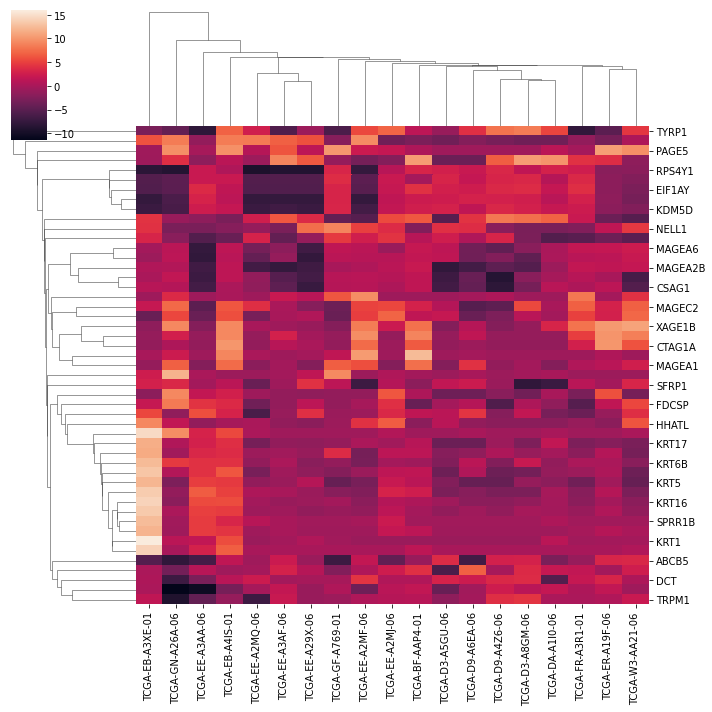

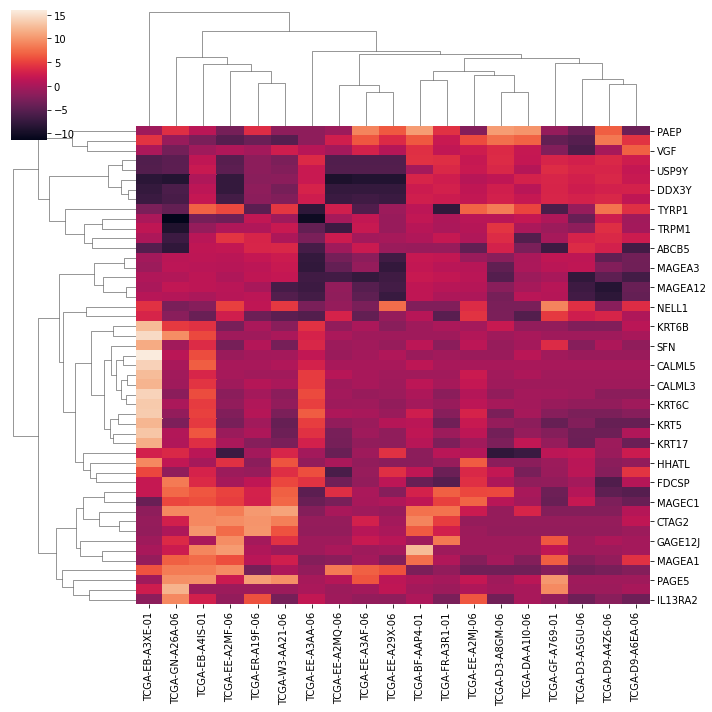

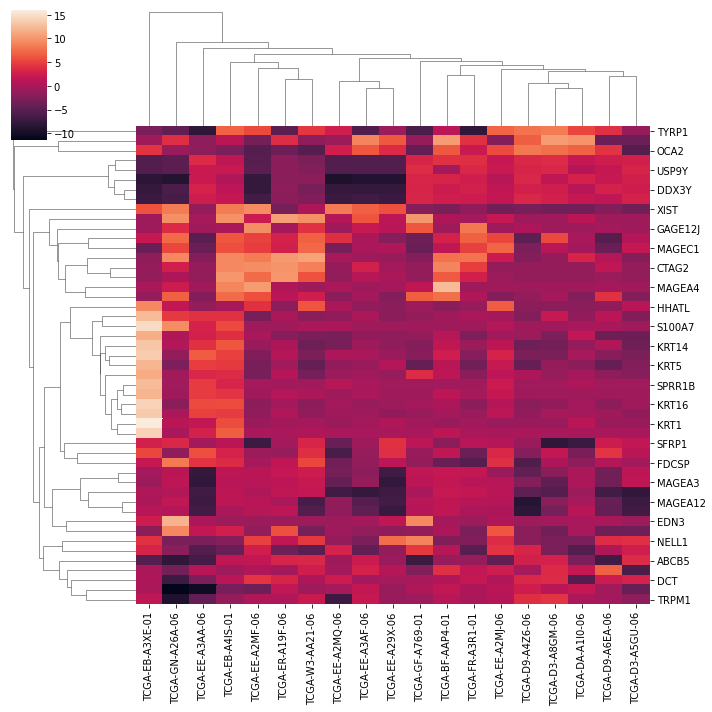

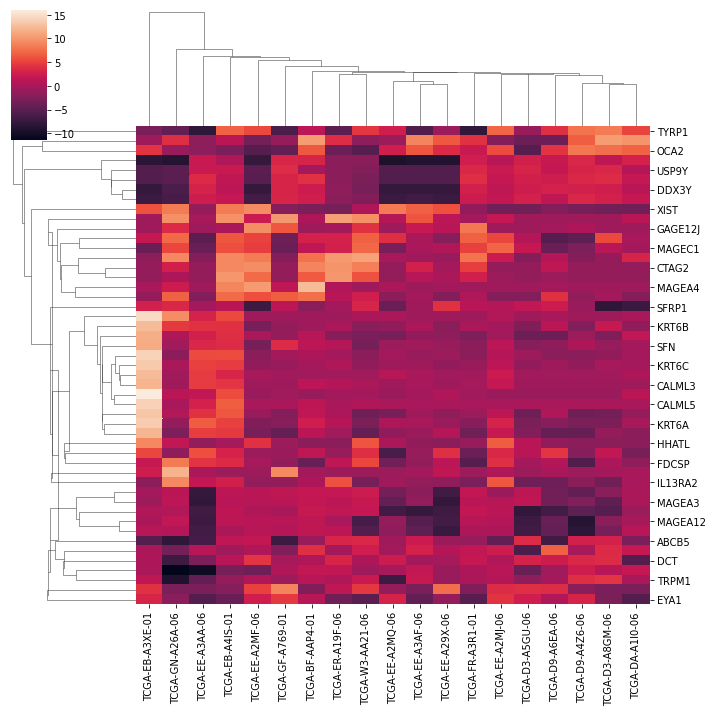

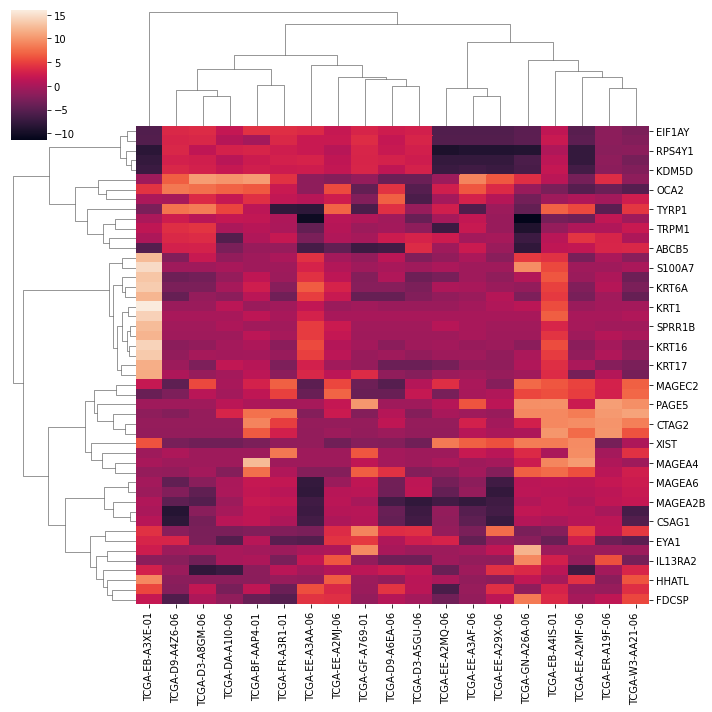

In [ ]:
sns.clustermap(mexpr_toy, metric="euclidean", method="single")
sns.clustermap(mexpr_toy, metric="euclidean", method="complete")
sns.clustermap(mexpr_toy, metric="euclidean", method="average")
sns.clustermap(mexpr_toy, metric="euclidean", method="centroid")
sns.clustermap(mexpr_toy, metric="euclidean", method="ward")

Parece que `complete` y `ward` son los que, para la distancia `euclidean`, ofrecen dendrogramas que visualmente se corresponden mejor con los conjuntos de muestras analizados en este conjunto de prueba pequeño

###2.2. Evaluación de los clusters obtenidos


Hasta ahora, estamos evaluando visualmente los resultados obtenidos por distintas variantes de clustering jerárquico para elegir el resultado que parece más coherente con los patrones observados. Esto nos está permitiendo entender cómo se interpretan los clusters y los dendrogramas, y validar los resultados obtenidos por los distintos métodos empleados. Mientras que la finalidad didáctica de esta forma de proceder es clara, es importante resaltar que en un problema de mayor tamaño probablemente será difícil apreciar a simple vista cuál de las posibles variantes de un algoritmo obtiene resultados más coherentes. Sin embargo, como ya se introdujo en la Cápsula 1 de este módulo, existen métricas para evaluar cuantitativamente y de forma automática los resultados obtenidos por distintos algoritmos o métodos de clustering. 

En la sección "¿Cómo elegimos el número de grupos $K$?"  estudiaremos algunas de estas medidas. 

###2.3. Anotaciones sobre los *heatmaps*

Los dendrogramas de los heatmaps pueden colorearse para indicar algunas categorías de los datos que sean relevantes para interpretar el gráfico. Por ejemplo, si tenemos muestras de distintos tipos tumorales, quizás sería interesante comprobar visualmente si los grupos detectados por el clustering jerárquico se corresponden o no con estas categorías de muestras. 

Las siguientes celdas de código ilustran cómo utilizar una variable adicional (en este caso, el tipo de tumor: primario o metastásico) para colorear las muestras según su tipo y comprobar visualmente si este tipo coincide con los clusters que se obtienen en el dendrograma. 

Para ello, primero descargamos los datos con información adicional sobre las muestras. 

In [ ]:
# Importamos la librería pandas con el alias 'pd'
import pandas as pd

# Almacenamos el enlace a nuestros datos en la variable 'url_datos'
url_datos = 'https://drive.google.com/uc?id=1ehBCICJrAqm5AUIDXca51IWIoyy-p9FY'

# El método read_csv permite leer un fichero de texto separado por deliminatdores, en nuestro caso, tabuladores ('\t')
base_datos = pd.read_csv(url_datos, delimiter='\t')

base_datos

definition  ... subtype_MUTATIONSUBTYPES
TCGA-D9-A4Z6-06A-12R-A266-07  Metastatic  ...                      NaN
TCGA-EE-A2MQ-06A-11R-A18S-07  Metastatic  ...                      NaN
TCGA-EE-A3AF-06A-11R-A18S-07  Metastatic  ...                      NaN
TCGA-ER-A19F-06A-11R-A18S-07  Metastatic  ...                      NaN
TCGA-EE-A2MF-06A-11R-A21D-07  Metastatic  ...                      NaN
...                                  ...  ...                      ...
TCGA-D3-A3MU-06A-11R-A21D-07  Metastatic  ...                      NaN
TCGA-EE-A2GO-06A-11R-A18S-07  Metastatic  ...                      NaN
TCGA-FR-A8YC-06A-11R-A37K-07  Metastatic  ...                      NaN
TCGA-DA-A1I2-06A-21R-A18U-07  Metastatic  ...                      NaN
TCGA-D3-A2JK-06A-11R-A18S-07  Metastatic  ...                      NaN

[473 rows x 3 columns]

Seleccionamos únicamente la columna `definition` que indica el tipo de tumor (`Primary solid Tumor` o `Metastatic`). Guardamos esta información en la variable `tipo_tumor`. Veamos esta información para las 20 primeras muestras. 

In [ ]:
tipo_tumor = base_datos.pop("definition")
tipo_tumor[0:19]

TCGA-D9-A4Z6-06A-12R-A266-07             Metastatic
TCGA-EE-A2MQ-06A-11R-A18S-07             Metastatic
TCGA-EE-A3AF-06A-11R-A18S-07             Metastatic
TCGA-ER-A19F-06A-11R-A18S-07             Metastatic
TCGA-EE-A2MF-06A-11R-A21D-07             Metastatic
TCGA-EE-A2MJ-06A-11R-A18S-07             Metastatic
TCGA-BF-AAP4-01A-11R-A40A-07    Primary solid Tumor
TCGA-D3-A8GM-06A-11R-A37K-07             Metastatic
TCGA-GN-A26A-06A-11R-A18T-07             Metastatic
TCGA-EB-A3XE-01A-12R-A239-07    Primary solid Tumor
TCGA-DA-A1I0-06A-11R-A20F-07             Metastatic
TCGA-FR-A3R1-01A-11R-A239-07    Primary solid Tumor
TCGA-EE-A3AA-06A-11R-A18S-07             Metastatic
TCGA-W3-AA21-06A-11R-A38C-07             Metastatic
TCGA-D9-A6EA-06A-11R-A311-07             Metastatic
TCGA-D3-A5GU-06A-11R-A27Q-07             Metastatic
TCGA-EE-A29X-06A-11R-A18T-07             Metastatic
TCGA-EB-A4IS-01A-21R-A266-07    Primary solid Tumor
TCGA-GF-A769-01A-32R-A32P-07    Primary solid Tumor
Name: defini

Volvemos a pintar el heatmap para este conjunto reducido de muestras, indicando que los colores de las columnas (argumento `col_colors` de la función `sns.clustermap`) son colores (rojo `r`, azul `b`, verde `g`, amarillo `y`) asociados a los distintos tipos de tumor según la variable `tipo_tumor`. Hemos utilizado cuatro colores porque esta variable tiene cuatro valores posibles, aunque en las 20 primeras muestras sólo aparecen el rojo (para el tipo `Metastatic`) y el azul (para el tipo `Primary solid Tumor`). 

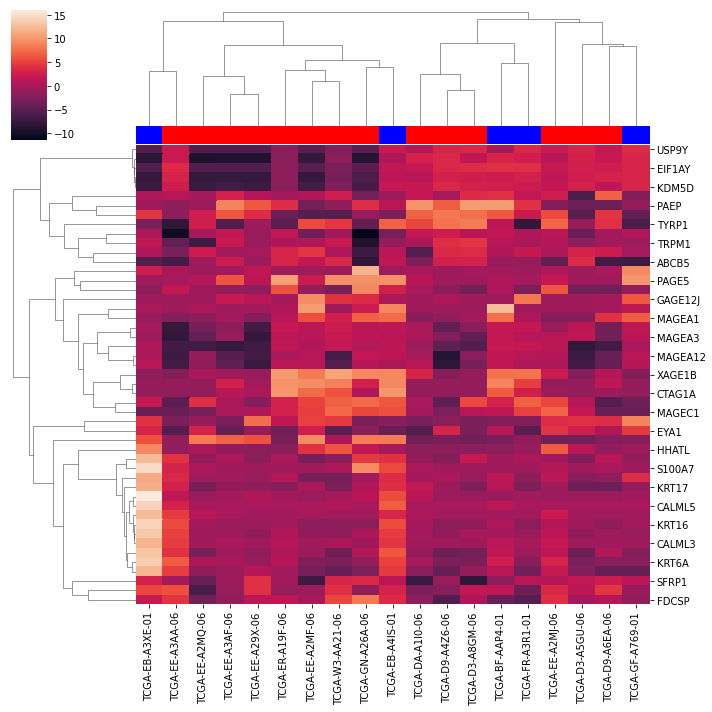

In [ ]:
color_map = dict(zip(tipo_tumor.unique(), "rbgy"))
sample_color = tipo_tumor.map(color_map)
sns.clustermap(mexpr_toy, metric="correlation", method="average", col_colors=list(sample_color[0:19]))

Podemos comprobar que, en este caso, no existe una correspondencia entre la categoría del tumor (primario o metastátisco) y los grupos de muestras obtenidos. Los perfiles de expresión de estos cincuenta genes nos están revelando otra forma distinta de agrupar las muestras que no se corresponde con esta categorización, ya conocida *a priori* para las muestras. 

Si utilizamos la matriz completa, los clusters obtenidos pueden ayudarnos a elaborar nuevas hipótesis sobre cuáles son las bases moleculares que revelan estos agrupamientos en las muestras. 

###2.4. Resultados sobre la matriz completa




Una vez validado el método más adecuado sobre instancias del problema más pequeñas, vamos a aplicar la mejor combinación de parámetros obtenida sobre la matriz de expresión completa. Para mejorar el resultado y la visualización de grupos por muestras, normalizamos los valores de las columnas al rango $[0,1]$ con el parámetro `standard_scale=1`.  

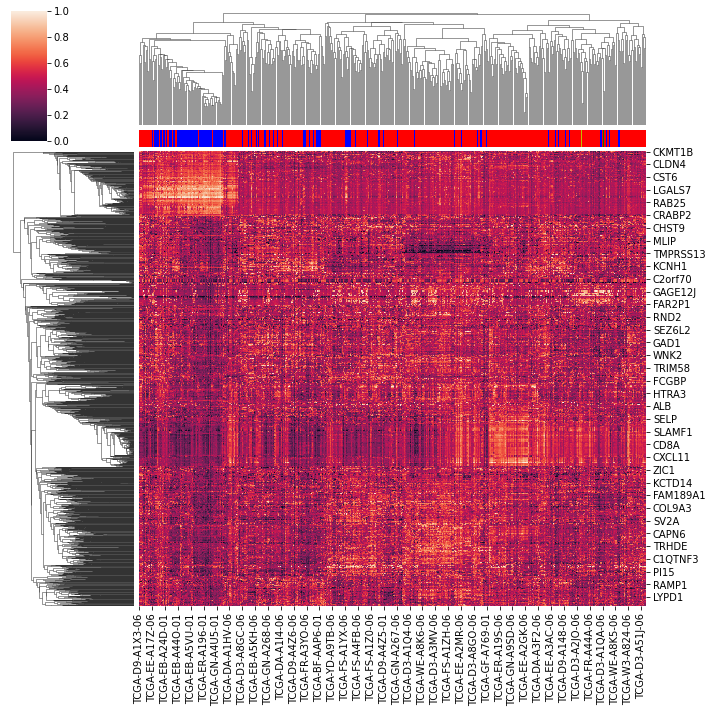

In [ ]:
color_map = dict(zip(tipo_tumor.unique(), "rbgy"))
color_map
sample_color = tipo_tumor.map(color_map)
sns.clustermap(mexpr, metric="correlation", method="average", col_colors=list(sample_color), standard_scale=1)


Los resultados obtenidos sobre la matriz completa son similares a aquellos obtenidos [por los propios autores del artículo de investigación en melanoma de piel de TCGA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/figure/F5/) o por los que obtuvimos utilizando R para añadir más información sobre las muestras en el Módulo 2 del curso: 
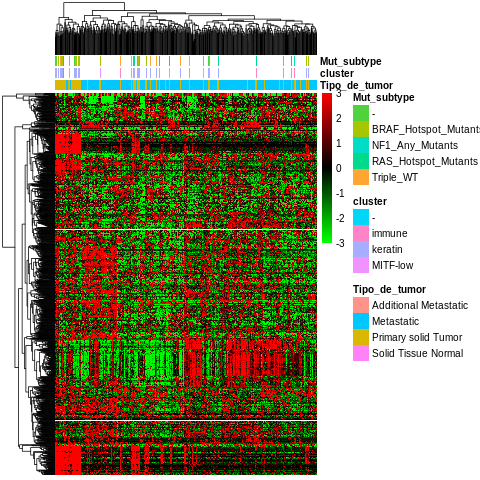

Con este resultado, los autores estudian como los grupos de muestras obtenidos de la matriz de expresión se relacionan con la información ya conocida sobre estas muestras y con el tiempo de supervivencia de los pacientes. Os recomendamos la lectura de este artículo de investigación (Referencia número 3 de esta Cápsula) para averiguar más al respecto. 



## **3. CLUSTERING POR PARTICIONAMIENTO: ALGORITMO K-MEDIAS** <a id='kmeans'></a>

K-medias es un algoritmo de agrupamiento por particiones cuyo objetivo es separar los objetos en $K$ conjuntos disjuntos minimizando la suma de distancias al cuadrado de los objetos de cada grupo. Para ello, el algoritmo necesita conocer *a priori* cuántos clusters hay en los datos (es decir, necesita conocer el valor de $K$). 

Como resultado de la ejecución de un algoritmo de K-medias el usuario obtiene los grupos resultantes (es decir, una asignación de objetos a cada grupo) y el *centroide* o representante de cada uno de los $K$ grupos.

Esto resulta novedoso respecto a los algoritmos de clustering jerárquico, porque nos proporciona una especie de objeto *representante* de todos los objetos de cada grupo. Por otra parte, una desventaja es que requiere que establezcamos a priori el valor de $K$, el número de grupos. 

Para aprender a aplicar el algoritmo de K-medias sobre datos de expresión genética y aprender a interpretar los resultados, comenzaremos utilizando una matriz de expresión pequeña, la matriz `mexpr_toy` generada en ejemplos anteriores. Tras entender cómo interpretar y visualizar los resultados, debatiremos sobre distintos medios para estimar *a priori* el valor de $K$, el número de clusters. Finalmente, aplicaremos los conocimientos adquiridos al análisis de una matriz de expresión completa. 

###3.1. Aprendemos a utilizar el algoritmo sobre un problema pequeño


En primer lugar, se ilustra cómo aplicar un algoritmo de k-medias sobre los datos de las muestras de la matriz de expresión `mexpr_toy` . A diferencia de la función `clustermap` anterior, con K-medias solo podemos aplicar el clustering simultáneamente sobre los genes o sobre las muestras de la matriz de expresión. La función de clustering que empleamos considera cada fila de la matriz como un objeto, así que en caso de querer realizar un clustering sobre las muestras (como en la siguiente celda de código), debemos primero trasponer la matriz. 

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing

# 1- Definimos el algoritmo a emplear y sus parámetros. 
# El número de clusters n_clusters es especialmente relevante para el resultado de este algoritmo
# Más información sobre posibles argumentos de KMeans aquí: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
k_means = KMeans(n_clusters=3)

# 2- Aplicamos el modelo de algoritmo definido en k_means sobre "datos"
# datos = mexpr                 # descomenta esta línea para hacer clustering de las filas de la matriz (genes)   
datos = mexpr_toy.transpose()   # descomenta esta línea para hacer clustering de las columnas de la matriz (muestras)
cluster_predict = k_means.fit_predict(datos)

# 3- Ponemos el resultado en una tabla para que sea más cómodo de manejar
clusters = pd.DataFrame(cluster_predict,index=datos.index,columns=['cluster'])

clusters


cluster
TCGA-D9-A4Z6-06        1
TCGA-EE-A2MQ-06        1
TCGA-EE-A3AF-06        0
TCGA-ER-A19F-06        0
TCGA-EE-A2MF-06        0
TCGA-EE-A2MJ-06        1
TCGA-BF-AAP4-01        0
TCGA-D3-A8GM-06        1
TCGA-GN-A26A-06        0
TCGA-EB-A3XE-01        2
TCGA-DA-A1I0-06        1
TCGA-FR-A3R1-01        0
TCGA-EE-A3AA-06        1
TCGA-W3-AA21-06        0
TCGA-D9-A6EA-06        1
TCGA-D3-A5GU-06        1
TCGA-EE-A29X-06        1
TCGA-EB-A4IS-01        0
TCGA-GF-A769-01        1

El resultado de este algoritmo es una tabla (dataframe) donde se indica el grupo correspondiente a cada muestra. Con estos datos podemos calcular el tamaño de cada cluster y qué porcentaje de objetos contiene respecto al total.

In [ ]:
print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.iteritems():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

Tamaño de cada cluster:
1:    10 (52.63%)
0:     8 (42.11%)
2:     1 ( 5.26%)


Para visualizar los perfiles de expresión genética asociados a cada uno de los clusters obtenidos, podemos utilizar un *heatmap* que muestre los perfiles de los *centroides* de cada grupo.

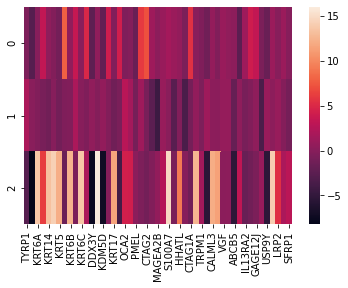

In [ ]:
centers = pd.DataFrame(k_means.cluster_centers_,columns=list(datos))
sns.heatmap(centers)


Si vuelves a ejecutar las tres últimas celdas de código (desde el inicio de la sección 3.1) podrás comprobar que, a diferencia de los resultados obtenidos por el clustering jerárquico, los resultados obtenidos por el algoritmo de K-medias cambian de una ejecución a otra. 

Esto es debido a que el resultado del algoritmo depende del valor inicial de los *centroides* (por defecto, se inicializan con valores aleatorios pero distantes unos de otros en el espacio de soluciones). 

La mayor parte de las ejecuciones de este algoritmo de K-medias derivan grupos de muestras de tamaño aproximado 60%, 35%, 5% de los objetos, respectivamente, en el que el grupo minoritario de muestras es un *outlier*. Se trata de un agrupamiento similar al que se observaba con el cluster jerárquico sobre esta misma matriz.  

###3.2. ¿Cómo elegimos el número de grupos $K$? <a id='chooseK'></a>

Es muy importante observar que el resultado de este algoritmo depende dramáticamente de la elección del valor de $K$. Por ejemplo, si ejecutamos el mismo código anterior pero con $K=2$

Tamaño de cada cluster:
0:    18 (94.74%)
1:     1 ( 5.26%)


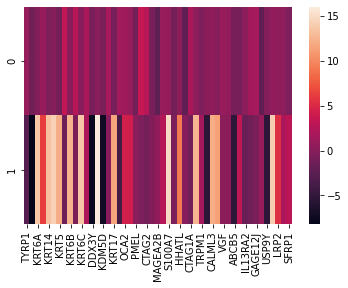

In [ ]:
k_means = KMeans(n_clusters=2)
datos = mexpr_toy.transpose()   
cluster_predict = k_means.fit_predict(datos)
clusters = pd.DataFrame(cluster_predict,index=datos.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.iteritems():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(datos))
sns.heatmap(centers)

Probablemente obtengamos (aunque el resultado cambia con cada ejecución) un cluster mayoritario del 95% de elementos y un *outlier* que conforma su propio grupo. Esta solución no resulta demasiado informativa (más allá de darnos a conocer que hay una muestra con comportamiento muy diferente al resto).   

De este modo estimar *a priori* el número de grupos de los datos es una tarea muy relevante y determinará en gran medida los resultados obtenidos por el algoritmo de Clustering. 

El procedimiento más común para realizar esta estimación es ejecutar el algoritmo de clustering para distintos valores de $K$ y evaluar comparativamente los resultados obtenidos, eligiendo aquellos que obtienen un mejor particionamiento de los datos. Para determinar el mejor resultado, se utilizan distintas métricas de bondad del agrupamiento. Las más populares son el índice Silueta (`silhouette`) y el índice de Calinski-Harabaz (`calinski_harabaz`). 

El siguiente código ilustra cómo calcular el valor de estos índices para distintos valores de $K$. El valor de $K$ que obtenga valores más altos para estos índices será el valor elegido. La función `yellowbrick.cluster.KElbowVisualizer` permite hacer todo este proceso con unas pocas líneas, representando gráficamente los valores de los índices obtenidos para los distintos $K$.   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee9a40a90>,
                 k=None, metric=None, model=None, timings=False)

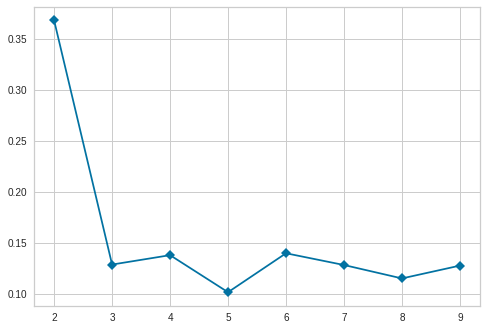

In [ ]:
from yellowbrick.cluster import KElbowVisualizer


datos = mexpr_toy.transpose()   
  
modelo = KMeans()
visualizer = KElbowVisualizer(modelo, k=(2,10), metric='silhouette', timings=False, locate_elbow=True)
visualizer.fit(datos)       
 

Por ejemplo, según el índice silueta, el valor óptimo de *K* es *2*. 
Probamos ahora con la métrica Calinski-Harabaz:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee99c7210>,
                 k=None, metric=None, model=None, timings=False)

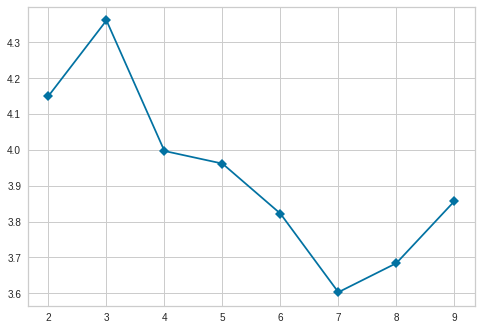

In [ ]:
visualizer = KElbowVisualizer(modelo, k=(2,10), metric='calinski_harabaz', timings=False, locate_elbow=True)
visualizer.fit(datos) 

Con Calinski-Harabaz el valor óptimo de *K* es 3. 

Si necesitamos calcular la bondad del clustering sobre un resultado concreto con los índices Silueta o Calinski-Harabaz, procederíamos como se muestra en la siguiente celda de código

In [ ]:
from math import floor

# 1- Hacemos el clustering
k_means = KMeans(n_clusters=3)
datos = mexpr_toy.transpose()   
cluster_predict = k_means.fit_predict(datos)

# 2- Con el resultado del cluster (cluster_predict) calculamos los índices Silueta y Calinski-Harabaz para ese resultado
indice_Silueta = metrics.silhouette_score(datos, cluster_predict)
print("Índice Silueta: "+str(indice_Silueta))
indice_CH = metrics.calinski_harabasz_score(datos, cluster_predict)
print("Índice Calinski-Harabaz: "+ str(indice_CH))



Índice Silueta: 0.12149573859682242
Índice Calinski-Harabaz: 4.26468963603073


###3.3. K-means en matrices de expresión completas

Con lo aprendido anteriormente, aplicamos K-medias en una matriz de expresión completa. Para ello, primero estimamos el número óptimo $K$. En estas estimaciones, activamos la opción `timings=True` para hacer que también se pinte en la gráfica una línea verde con el tiempo que consume el clustering por cada valor de $K$ que se prueba


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee990c350>,
                 k=None, metric=None, model=None, timings=True)

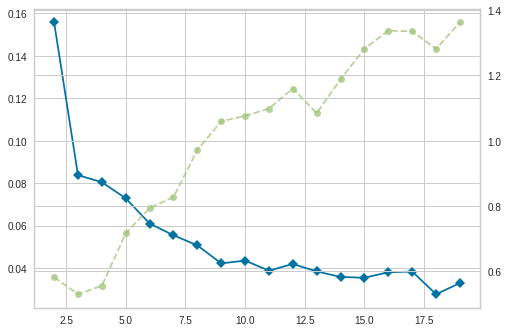

In [ ]:
from yellowbrick.cluster import KElbowVisualizer


datos = mexpr.transpose()   
  
modelo = KMeans()

visualizer = KElbowVisualizer(modelo, k=(2,20), metric='silhouette', timings=True, locate_elbow=True)
visualizer.fit(datos)       


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbee99e7210>,
                 k=None, metric=None, model=None, timings=True)

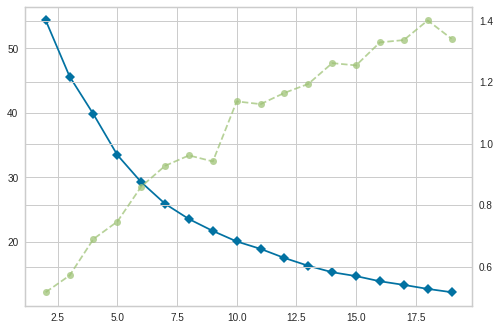

In [ ]:
visualizer = KElbowVisualizer(modelo, k=(2,20), metric='calinski_harabaz', timings=True, locate_elbow=True)
visualizer.fit(datos)       

De la vista de ambas gráficas, parece que $K=2$ es el resultado más fiel a la estructura y variabilidad de los datos subyacentes. Aplicamos k-medias para $K=2$ y pintamos los centroides resultantes

Tamaño de cada cluster:
0:   403 (85.20%)
1:    70 (14.80%)


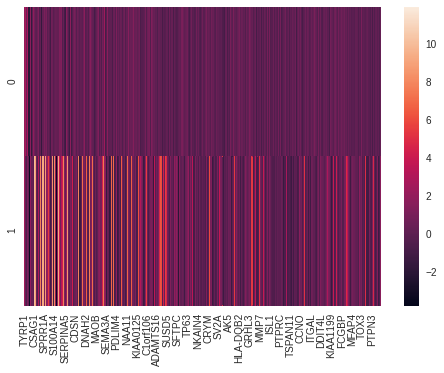

In [ ]:
k_means = KMeans(n_clusters=2)
datos = mexpr.transpose()   
cluster_predict = k_means.fit_predict(datos)
clusters = pd.DataFrame(cluster_predict,index=datos.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters['cluster'].value_counts()
for num,i in size.iteritems():
   print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))

centers = pd.DataFrame(k_means.cluster_centers_,columns=list(datos))
sns.heatmap(centers)

## **4. CONTENIDO ADICIONAL**

###4.1. Detección de *outliers*

La función `sns.clustermap` permite identificar y omitir `outliers` de la representación del resultado. 

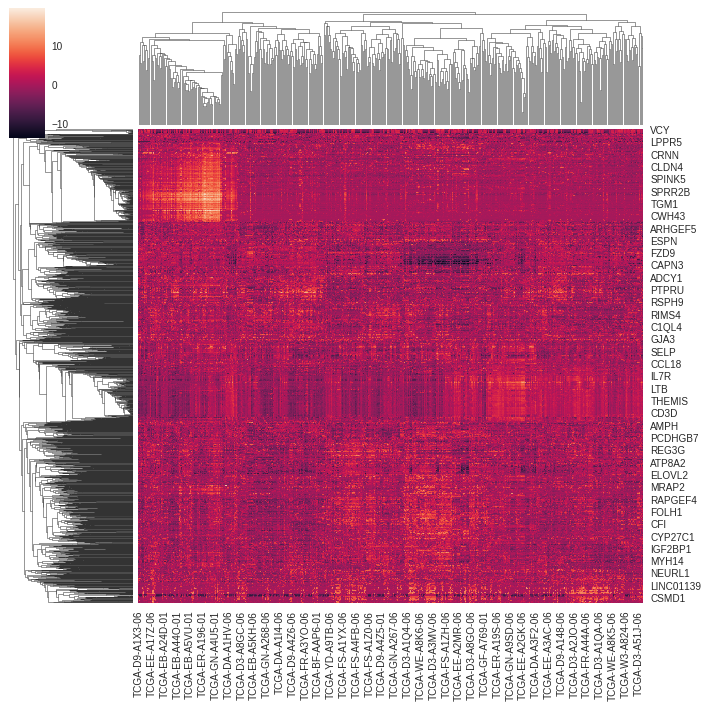

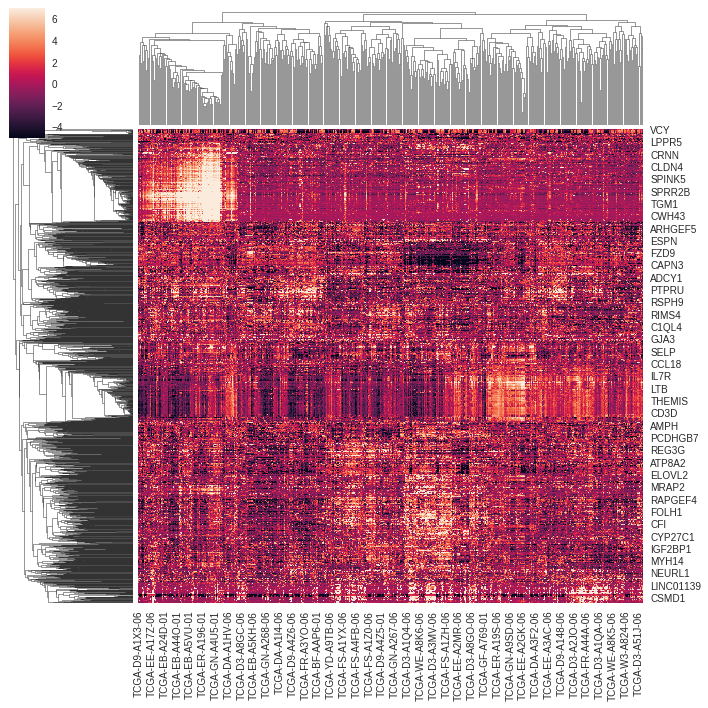

In [ ]:

# ejecución normal
sns.clustermap(mexpr, metric="correlation", method="average")

# ejecución utilizando detección de outliers
sns.clustermap(mexpr, metric="correlation", method="average", robust=True)
 

###4.2. Cambios en la representación gráfica

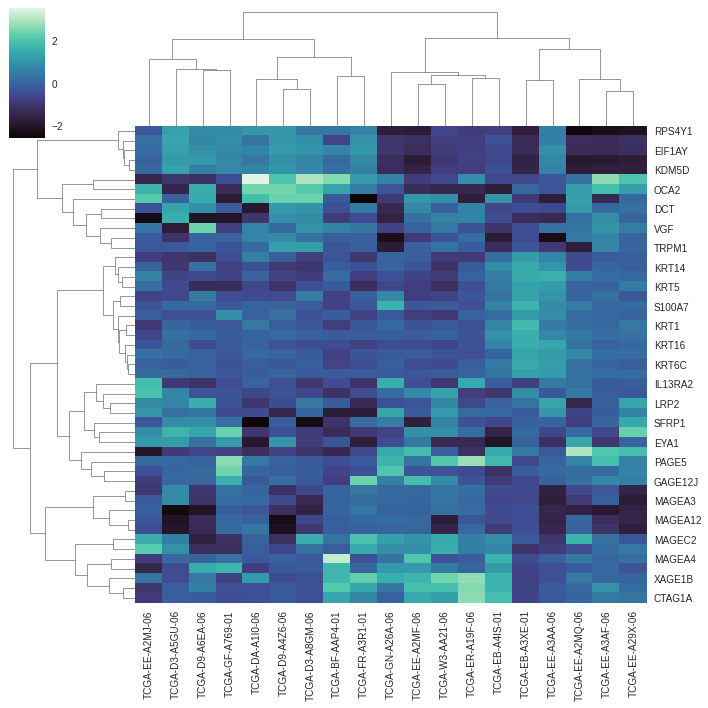

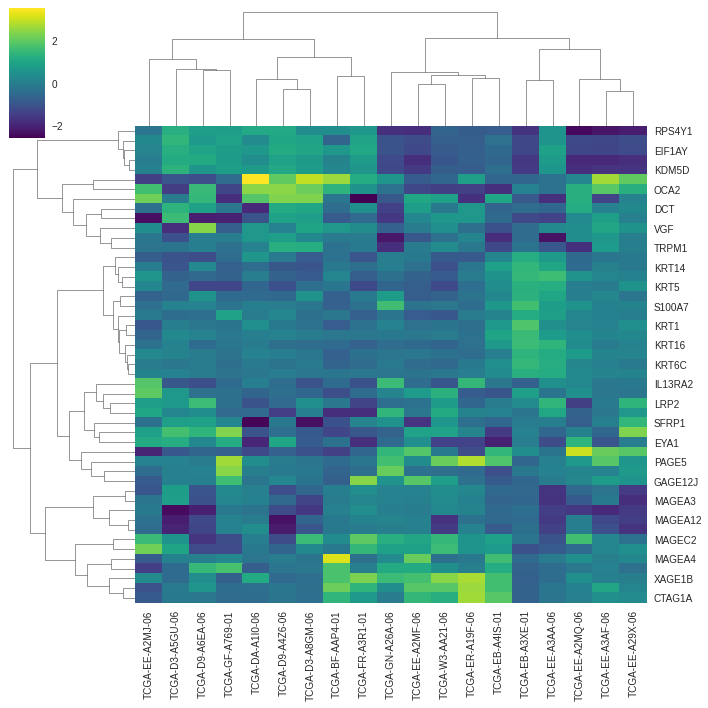

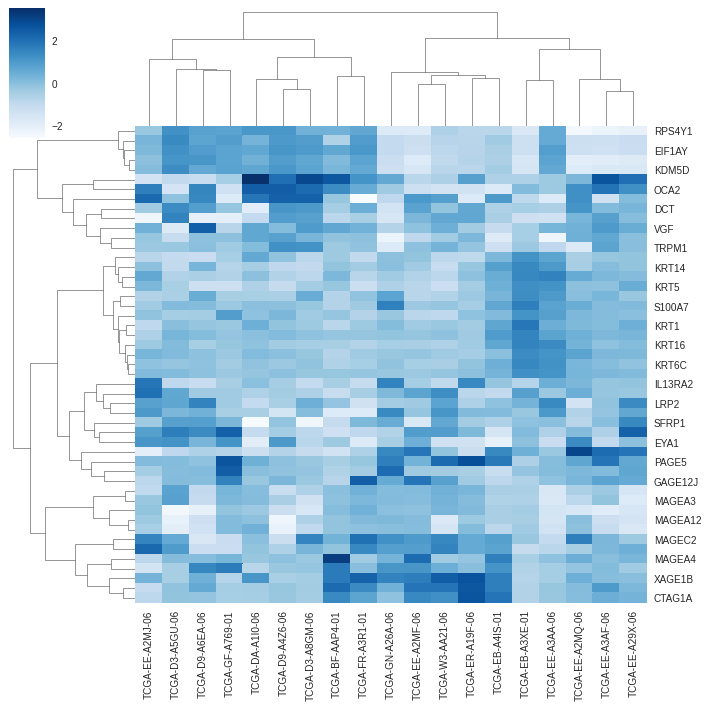

In [ ]:


# Cambios en la paleta de colores
sns.clustermap(mexpr_toy, metric="euclidean", z_score=1, method="ward", cmap="mako")
sns.clustermap(mexpr_toy, metric="euclidean", z_score=1, method="ward", cmap="viridis")
sns.clustermap(mexpr_toy, metric="euclidean", z_score=1, method="ward", cmap="Blues")


###4.3. Normalización de los datos

La función `clustermap` permite llevar a cabo transformaciones sobre los datos de entrada: 
- la estandarización del rango de las variables a $[0,1]$ (parámetro `standard_scale=0` para aplicar esta transformación a las filas, `standard_scale=1` para aplicarla a las columnas) 
- normalización calculando *z-score* (parámetro `z_score=0` para aplicar esta transformación a las filas, `z_score=1` para aplicarla a las columnas) 

De este modo, en caso de que nuestros datos de partida no estén normalizados, pueden utilizarse estas opciones para hacerlo en la misma función `clustermap`. En nuestro caso, mostramos estas opciones para ilustrar sus efectos sobre los datos, aunque la normalización de esta matriz de expresión ya se ha llevado a cabo en el Módulo 2, así que no necesitamos aplicar más medidas de normalización. 

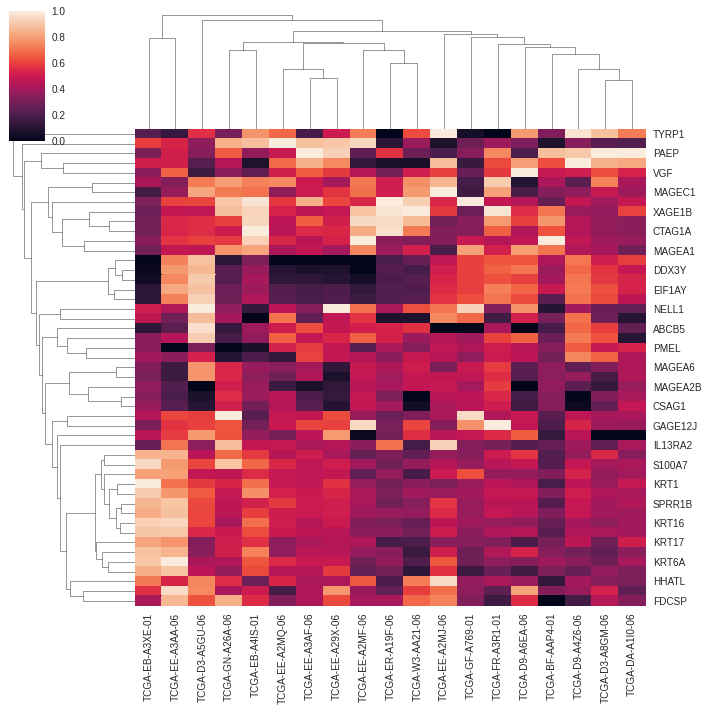

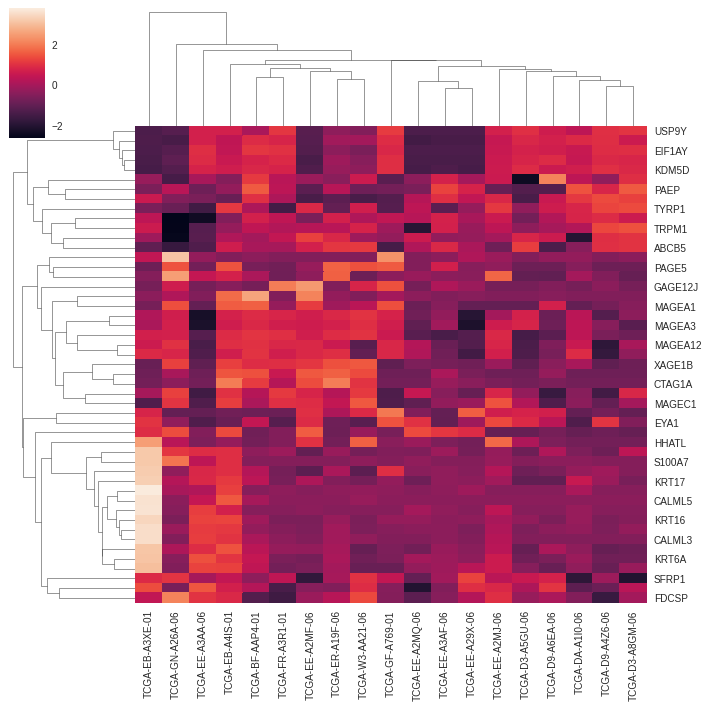

In [ ]:
# Estandarización:
sns.clustermap(mexpr_toy, standard_scale=1)
# Normalización (z-score)
sns.clustermap(mexpr_toy, z_score=0)


###4.4. Clustering jerárquico sólo en filas o columnas


Para efectuar clustering jerárquico sólo sobre las filas (genes), necesitamos utilizar los siguientes parámetros

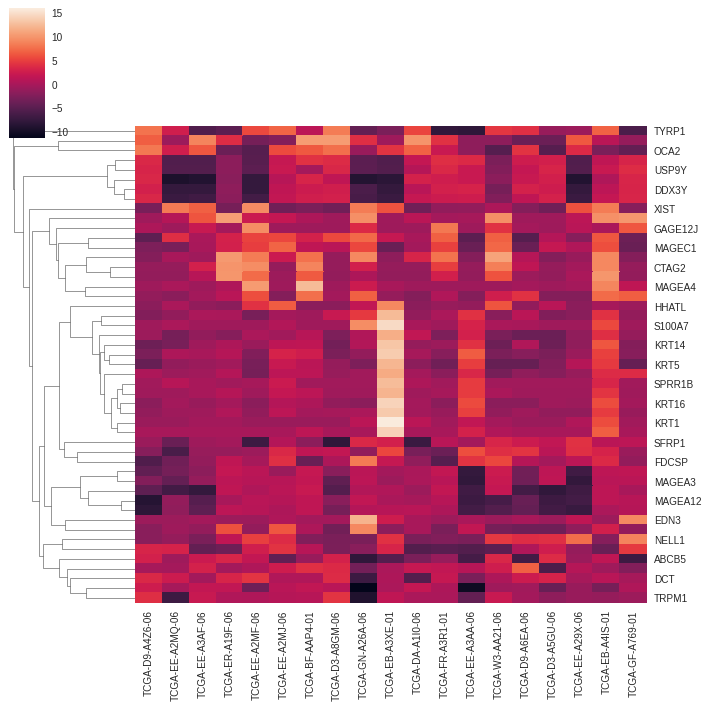

In [ ]:
sns.clustermap(mexpr_toy, row_cluster=True, col_cluster=False)

Para efectuar sólo el cluster sobre las columnas

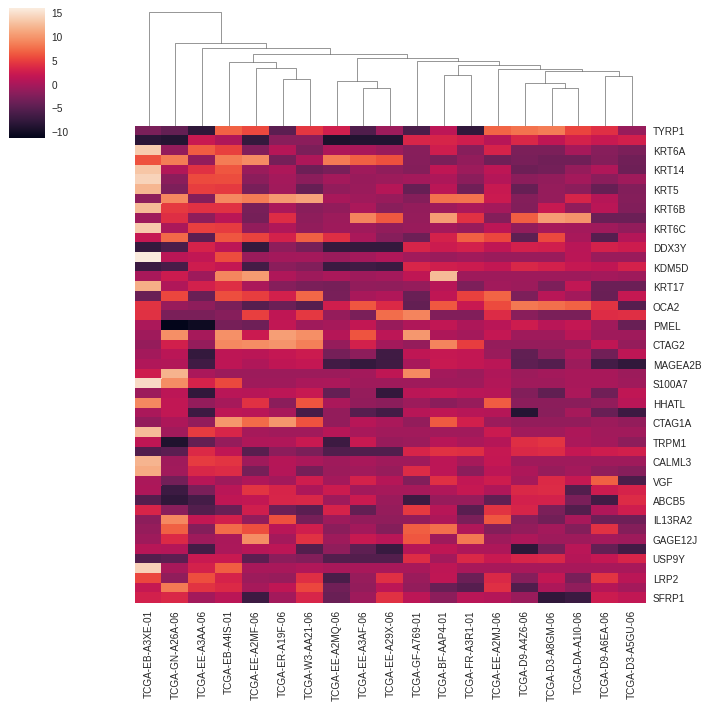

In [ ]:
sns.clustermap(mexpr_toy, row_cluster=False, col_cluster=True)

###4.5. ¿Y ahora qué? Más algoritmos de clustering


Existen numerosos algoritmos de clustering ya implementados en Python. Tras finalizar este módulo, os recomendamos explorar los tutoriales de Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. En particular, el capítulo de Clustering: https://scikit-learn.org/stable/modules/clustering.html#clustering 

#**REFERENCIAS BIBLIOGRÁFICAS**
 
* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. En particular, el capítulo de Clustering: https://scikit-learn.org/stable/modules/clustering.html#clustering 
* Seaborn Clustermap https://seaborn.pydata.org/generated/seaborn.clustermap.html
* Cancer Genome Atlas Network. Genomic Classification of Cutaneous Melanoma. Cell. 2015;161(7):1681‐1696. doi:10.1016/j.cell.2015.05.044 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/

<div class="alert alert-block alert-success">

MOOC Machine Learning y Big Data para la Bioinformática (1ª edición)   
http://abierta.ugr.es     
    
</div>    
